In [1]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Display options
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

In [2]:
# Adjust the path if needed
csv_path = "C:/Users/hasan/OneDrive/Desktop/Apziva/1. Happy Customers Project/ACME-HappinessSurvey2020.csv"
assert os.path.exists(csv_path), f"Dataset not found at {csv_path}. Place the CSV next to this notebook."

df = pd.read_csv(csv_path)
df.head()

Y  X1  X2  X3  X4  X5  X6
0  0   3   3   3   4   2   4
1  0   3   2   3   5   4   3
2  1   5   3   3   3   3   5
3  0   5   4   3   3   3   5
4  0   5   4   3   3   3   5

In [3]:
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nData types:")
print(df.dtypes)

print("\nDescriptive statistics:")
print(df.describe())

Shape: (126, 7)
Columns: ['Y', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6']

Data types:
Y     int64
X1    int64
X2    int64
X3    int64
X4    int64
X5    int64
X6    int64
dtype: object

Descriptive statistics:
                Y          X1          X2          X3          X4          X5          X6
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000
mean     0.547619    4.333333    2.531746    3.309524    3.746032    3.650794    4.253968
std      0.499714    0.800000    1.114892    1.023440    0.875776    1.147641    0.809311
min      0.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000
25%      0.000000    4.000000    2.000000    3.000000    3.000000    3.000000    4.000000
50%      1.000000    5.000000    3.000000    3.000000    4.000000    4.000000    4.000000
75%      1.000000    5.000000    3.000000    4.000000    4.000000    4.000000    5.000000
max      1.000000    5.000000    5.000000    5.000000    5.000000    5.000000

In [4]:
missing = df.isna().sum().sort_values(ascending=False)
print("Missing values per column:")
print(missing)

print("\nTarget distribution:")
print(df["Y"].value_counts(dropna=False))

Missing values per column:
Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

Target distribution:
Y
1    69
0    57
Name: count, dtype: int64


In [5]:
expected_features = [f"X{i}" for i in range(1, 7)]
available_features = [c for c in expected_features if c in df.columns]
available_features

['X1', 'X2', 'X3', 'X4', 'X5', 'X6']

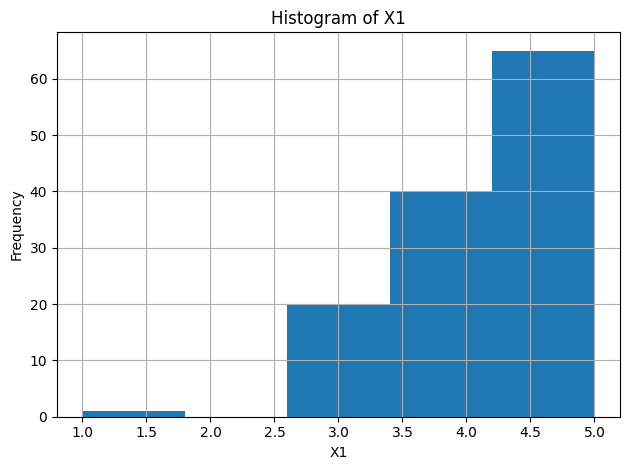

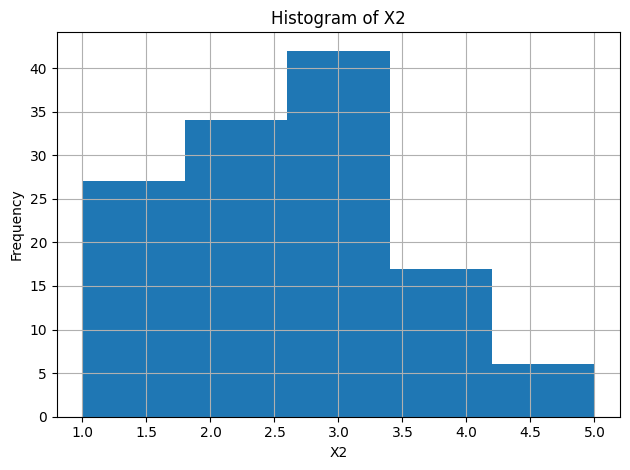

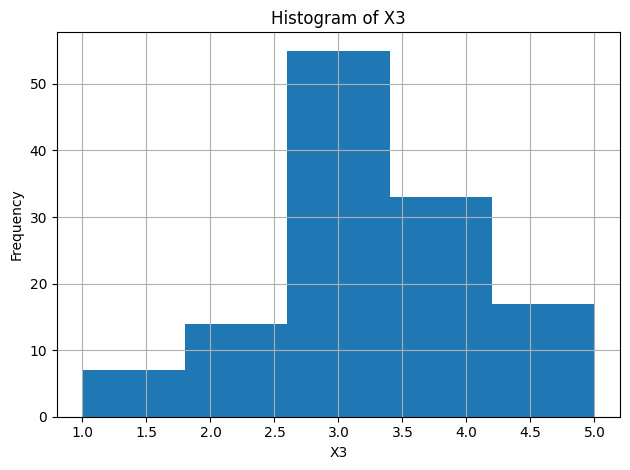

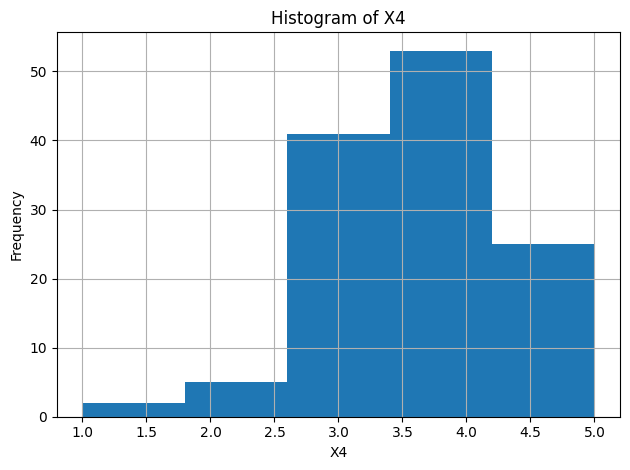

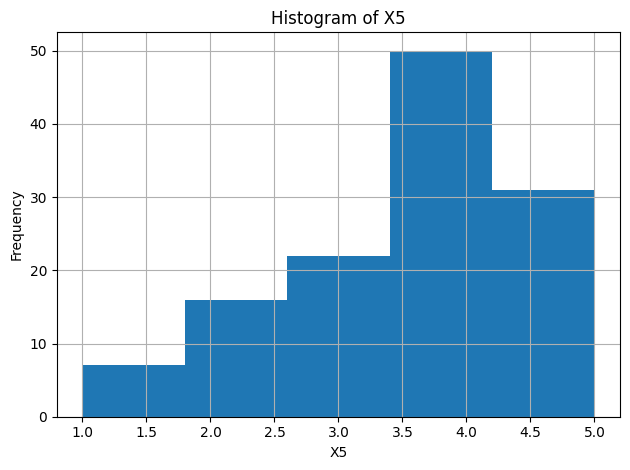

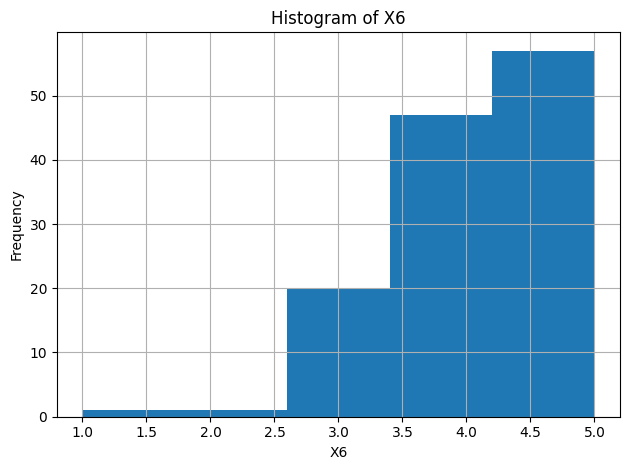

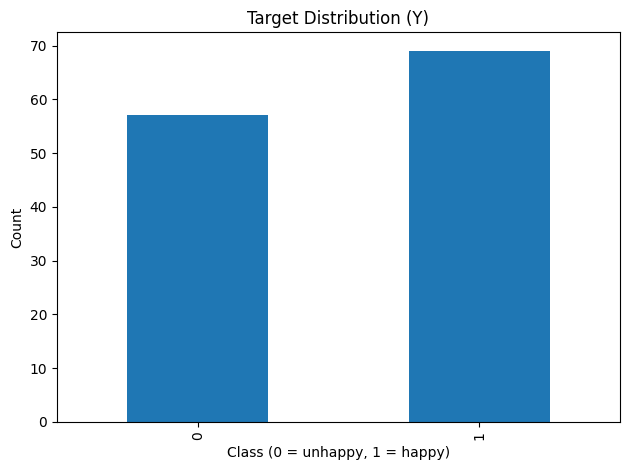

In [6]:
# Histograms for X1..X6
for col in available_features:
    plt.figure()
    df[col].hist(bins=5)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Bar chart for class distribution
plt.figure()
df["Y"].value_counts().sort_index().plot(kind="bar")
plt.title("Target Distribution (Y)")
plt.xlabel("Class (0 = unhappy, 1 = happy)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

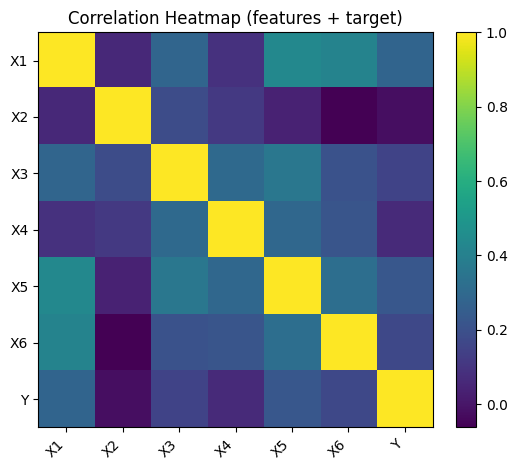

In [7]:
# Correlation heatmap (matplotlib only)
plt.figure()
corr = df[available_features + ["Y"]].corr(numeric_only=True)
im = plt.imshow(corr, interpolation="nearest")
plt.title("Correlation Heatmap (features + target)")
plt.xticks(ticks=range(corr.shape[1]), labels=corr.columns, rotation=45, ha="right")
plt.yticks(ticks=range(corr.shape[0]), labels=corr.index)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [8]:
X = df[available_features].copy()
y = df["Y"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((94, 6), (32, 6))


=== LogisticRegression ===
Accuracy: 0.7188
Precision: 0.6957
Recall: 0.8889
F1: 0.7805
ROC-AUC: 0.7817


<Figure size 640x480 with 0 Axes>

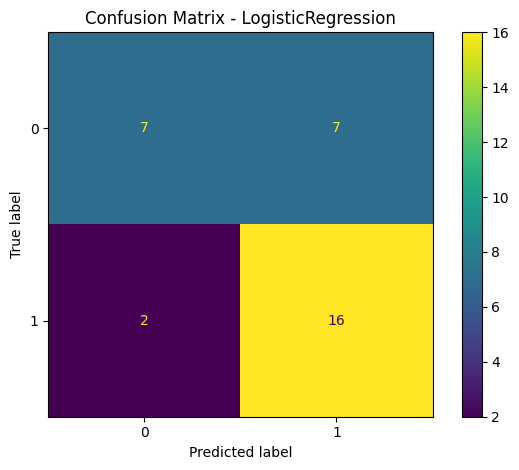


=== RandomForest ===
Accuracy: 0.6562
Precision: 0.7059
Recall: 0.6667
F1: 0.6857
ROC-AUC: 0.7262


<Figure size 640x480 with 0 Axes>

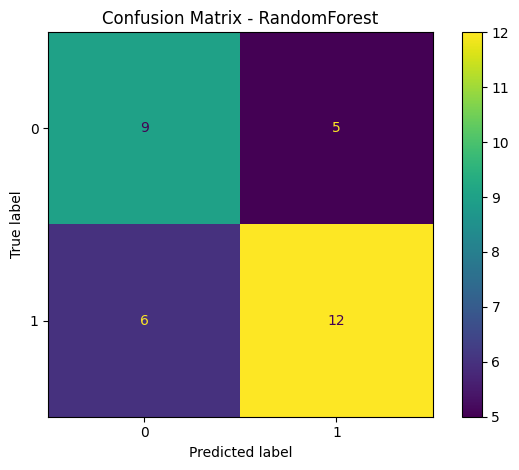

model  accuracy  precision    recall        f1   roc_auc
0  LogisticRegression   0.71875   0.695652  0.888889  0.780488  0.781746
1        RandomForest   0.65625   0.705882  0.666667  0.685714  0.726190

In [9]:

models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500, solver="lbfgs"))
    ]),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight=None
    )
}

rows = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = None
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except Exception:
        pass
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else float("nan")
    
    rows.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc
    })
    
    print(f"\n=== {name} ===")
    print("Accuracy:", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall:", round(rec, 4))
    print("F1:", round(f1, 4))
    if not math.isnan(roc):
        print("ROC-AUC:", round(roc, 4))
    
    # Confusion matrix
    plt.figure()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

metrics_df = pd.DataFrame(rows).sort_values(by="accuracy", ascending=False).reset_index(drop=True)
metrics_df


In [10]:

# Logistic Regression coefficients (standardized)
lr_pipe = models["LogisticRegression"]
lr_pipe.fit(X_train, y_train)
lr_clf = lr_pipe.named_steps["clf"]
lr_coefs = lr_clf.coef_.ravel()

coef_df = pd.DataFrame({
    "feature": available_features,
    "lr_coef": lr_coefs
}).sort_values("lr_coef", key=lambda s: s.abs(), ascending=False)
coef_df


feature   lr_coef
0      X1  0.266978
4      X5  0.247972
1      X2 -0.162577
2      X3  0.077244
5      X6 -0.053889
3      X4  0.012056

In [11]:

# Random Forest importances
rf = models["RandomForest"]
rf.fit(X_train, y_train)
imp_df = pd.DataFrame({
    "feature": available_features,
    "rf_importance": rf.feature_importances_
}).sort_values("rf_importance", ascending=False)
imp_df


feature  rf_importance
2      X3       0.201967
1      X2       0.188306
4      X5       0.177055
3      X4       0.161492
0      X1       0.153482
5      X6       0.117698

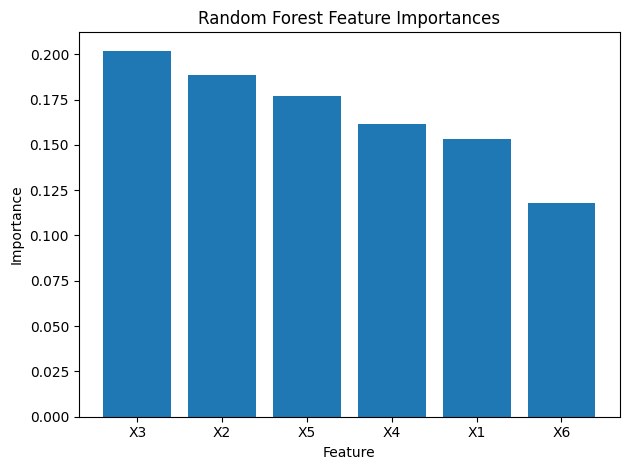

In [12]:

plt.figure()
plt.bar(imp_df["feature"], imp_df["rf_importance"])
plt.title("Random Forest Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [13]:

best_model_name = metrics_df.iloc[0]["model"]
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

perm = permutation_importance(best_model, X_test, y_test, n_repeats=20, random_state=42)
perm_df = pd.DataFrame({
    "feature": available_features,
    "permutation_importance_mean": perm.importances_mean,
    "permutation_importance_std": perm.importances_std
}).sort_values("permutation_importance_mean", ascending=False)
perm_df


feature  permutation_importance_mean  permutation_importance_std
0      X1                     0.104688                    0.046640
4      X5                     0.051562                    0.059519
1      X2                     0.046875                    0.033512
2      X3                     0.023438                    0.013532
5      X6                     0.014063                    0.020905
3      X4                     0.000000                    0.000000

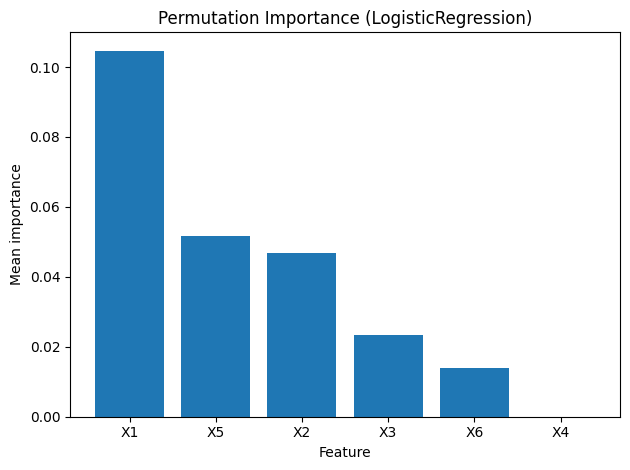

In [14]:

plt.figure()
plt.bar(perm_df["feature"], perm_df["permutation_importance_mean"])
plt.title(f"Permutation Importance ({best_model_name})")
plt.xlabel("Feature")
plt.ylabel("Mean importance")
plt.tight_layout()
plt.show()


In [15]:

def evaluate_subset(features, model):
    X_tr = X_train[features]
    X_te = X_test[features]
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    return accuracy_score(y_test, y_pred)

selected = []
best_acc = 0.0
progress = []
for _ in range(len(available_features)):
    best_feat = None
    best_score_round = best_acc
    for feat in available_features:
        if feat in selected:
            continue
        trial = selected + [feat]
        score = evaluate_subset(trial, models[best_model_name])
        if score > best_score_round:
            best_score_round = score
            best_feat = feat
    if best_feat is not None:
        selected.append(best_feat)
        best_acc = best_score_round
        progress.append({
            "k_features": len(selected),
            "feature_added": best_feat,
            "accuracy": best_acc
        })
    else:
        break

subset_df = pd.DataFrame(progress)
subset_df


k_features feature_added  accuracy
0           1            X6   0.71875

In [16]:

if not subset_df.empty:
    print("Suggested order by incremental gain:")
    print(" -> ".join(subset_df["feature_added"]))
    print("\nBest accuracy with", len(subset_df), "features:", round(subset_df.iloc[-1]["accuracy"], 4))
else:
    print("No improvement found beyond the starting point.")


Suggested order by incremental gain:
X6

Best accuracy with 1 features: 0.7188
